<a href="https://colab.research.google.com/github/Abhishek92kumar/LJMU/blob/main/publaynet_loading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
!pip install webdataset

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 3.6 MB/s eta 0:00:00


In [4]:
import webdataset as wds
import pprint
import numpy as np
from itertools import islice
import torch
figsize(20, 10)
pp = pprint.PrettyPrinter(indent=2, compact=True, width=150, depth=2).pprint
cache_dir = None

# Loading PubLayNet from the Web

Datasets are accessible directly over the web. However, you can also store them locally, in network file systems, or in any object store.

In [5]:
# urls = "http://storage.googleapis.com/lpr-publaynet/publaynet-train-{000000..000340}.tar"

In [13]:
urls =  "https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-0.tar.gz"

Datasets are just `.tar` archives containing training files. For PubLayNet, each training sample consists of a `.png` file and a corresponding `.json` file.

In [14]:
!curl {urls} | tar xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 12.6G  100 12.6G    0     0  3976k      0  0:55:45  0:55:45 --:--:-- 2732k


In [22]:
eval = "https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/labels.tar.gz"

In [23]:
!curl {eval} | tar xz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  313M  100  313M    0     0  5766k      0  0:00:55  0:00:55 --:--:-- 8604k


In [12]:
# !curl -s -L https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/train-0.tar.gz | tar tvf - | sed 10q


tar: Archive is compressed. Use -z option
tar: Error is not recoverable: exiting now


We're instantiating a simple WebDataset without shuffling but with local caching. We'll later construct a more elaborate instance for training.

In [5]:
ds = wds.WebDataset(urls, shardshuffle=False, cache_dir=cache_dir).decode("rgb8")

NameError: ignored

WebDataset instances are just instances of PyTorch's IterableDataset

In [25]:
isinstance(ds, torch.utils.data.IterableDataset)

True

You can iterate over a WebDataset instance just like you would over any other IterableDataset. By default, you get back a dictionary containing all the files making up the sample. The .decode() method above takes care of decoding.

In [1]:
for sample in ds:
    print(sample.keys())
    imshow(sample["jpg"])
    break

NameError: ignored

# Making Ground Truth

The `.json` file contains all the layout training information, and other metainfo. However, JSON isn't a good target format for training, so we need to convert the JSON into some training target. In this case, we want to perform semantic segmentation, so we construct a semantic segmentation target from the annotations.

In [27]:
pp(sample["json"])

KeyError: ignored

In [21]:
pp(sample["json"]["annotations"][0])

KeyError: ignored

This is just a very simple function that renders the bounding boxes of the ground truth into an image. For actual training, you probably want to render the actual segmentation, not just its bounding box, and maybe modify the target image in other ways.

In [ ]:
def make_gt(sample):
    image = sample["png"]
    json = sample["json"]
    h, w = image.shape[:2]
    result = np.zeros((h, w), dtype=np.uint8)
    for region in json["annotations"]:
        x, y, w, h = [int(x) for x in region["bbox"]]
        result[y:y+h, x:x+w] = region["category_id"]
    sample["seg.png"] = result
    return sample

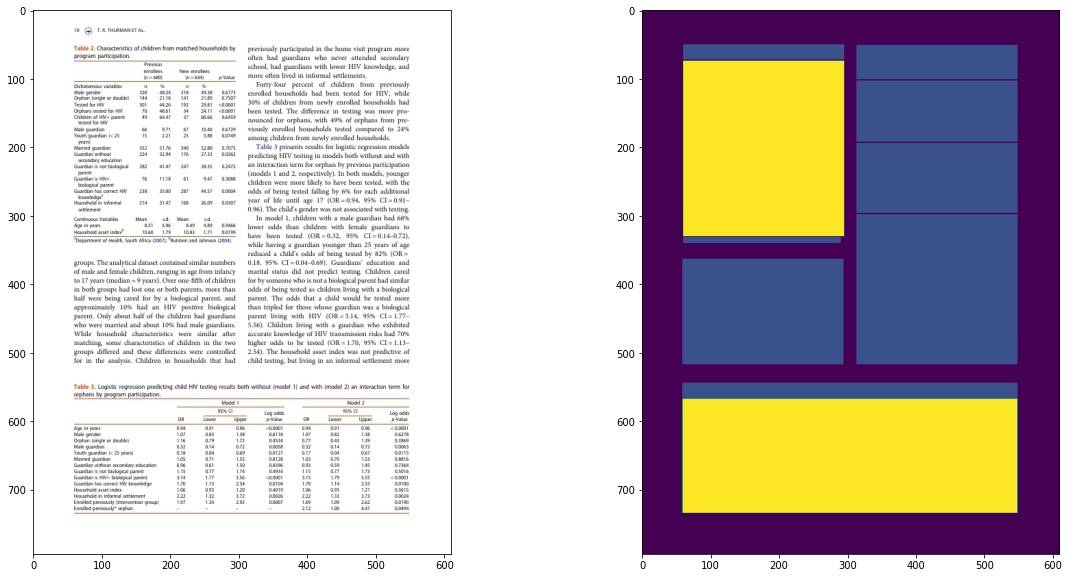

In [ ]:
figsize(20, 10)
sample = make_gt(sample)
subplot(121); imshow(sample["png"])
subplot(122); imshow(sample["seg.png"])

# Training with PyTorch

Let's now write a data loader we can actually use for training. First, we generate the ground truth image and then convert the training sample into a tuple.

In [ ]:
ds = wds.WebDataset(urls, shardshuffle=False, cache_dir=cache_dir).decode("rgb8").map(make_gt).to_tuple("png", "seg.png")

Since we want to batch the data, we need to make sure that all the images are the same size. Here is a simple crop function that does this. Again, you may want to use something more elaborate for actual training.

In [ ]:
def simple_crop(image, shape=(800, 700)):
    if image.ndim == 3:
        image = image.transpose(2, 0, 1)
        image = torch.tensor(image)
        result = torch.zeros((3,) + shape, dtype=image.dtype)
        d, h, w = np.minimum((3,) + shape, image.shape)
        result[:d, :h, :w] = image[:d, :h, :w]
        return result
    elif image.ndim == 2:
        image = torch.tensor(image)
        result = torch.zeros(shape, dtype=image.dtype)
        h, w = np.minimum(shape, image.shape)
        result[:h, :w] = image[:h, :w]
        return result        

We add two more processing stages to the input pipeline; the first inverts the input image, the second performs the cropping.

In [ ]:
ds = ds.map_tuple(lambda x: 1-x).map_tuple(simple_crop, simple_crop)

Now we can instantiate a WebLoader (a small wrapper around Torch's DataLoader) to perform the batching and parallel I/O.

In [ ]:
dl = wds.WebLoader(ds, batch_size=8, num_workers=2)

Finally, we can put this into a training loop.

torch.Size([8, 3, 800, 700]) torch.Size([8, 800, 700])


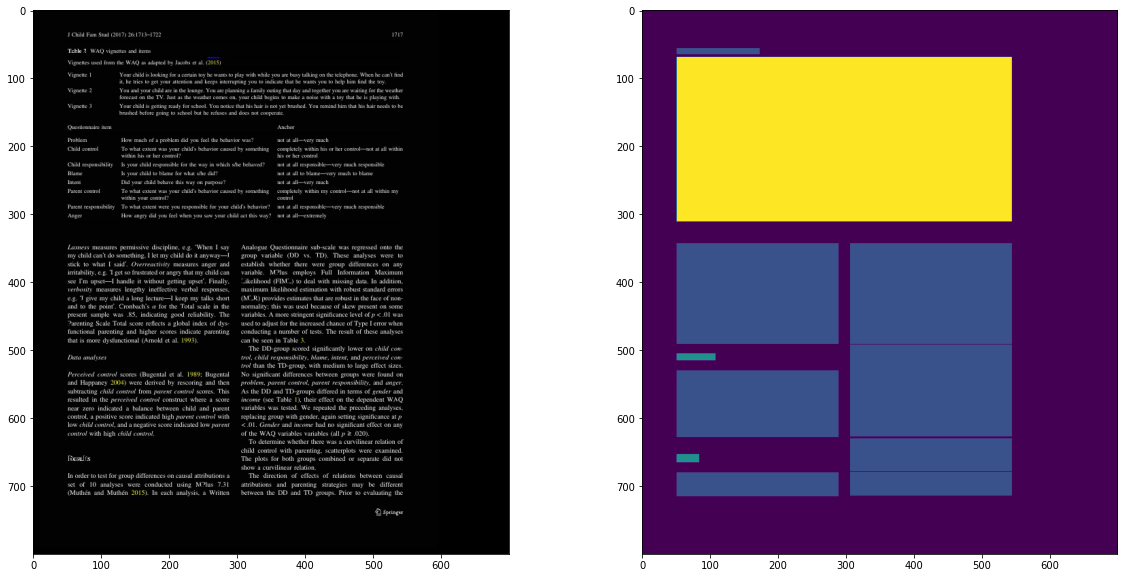

In [ ]:
debug = True

for inputs, targets in dl:
    
    if debug:
        print(inputs.shape, targets.shape)
        index = 3
        subplot(121); imshow(inputs[index].permute(1, 2, 0).numpy())
        subplot(122); imshow(targets[index].numpy())
        break
    
    train_batch(inputs, targets)

Note that if you set the `cache_dir` variable to some local directory, WebDataset will cache training data in that directory as it is training. This is useful if you have lots of local storage and a slow network connection. On the other hand, if you have a fast network connection and little local storage (e.g., if you're running in a container), you can set `cache_dir = None` and training data will be streamed continuously over the network as needed (this is still much faster than a network file system).